In [2]:
%matplotlib ipympl
import datetime

import qiskit
import qiskit_finance
from qiskit_finance.data_providers import YahooDataProvider
from qiskit_finance.applications.optimization.portfolio_optimization import (
    PortfolioOptimization,
)
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA, SamplingVQE
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_aer.primitives import Sampler
from qiskit.circuit.library import TwoLocal

interactive(children=(DatePicker(value=datetime.datetime(2024, 1, 1, 0, 0), description='Start date', step=1),…

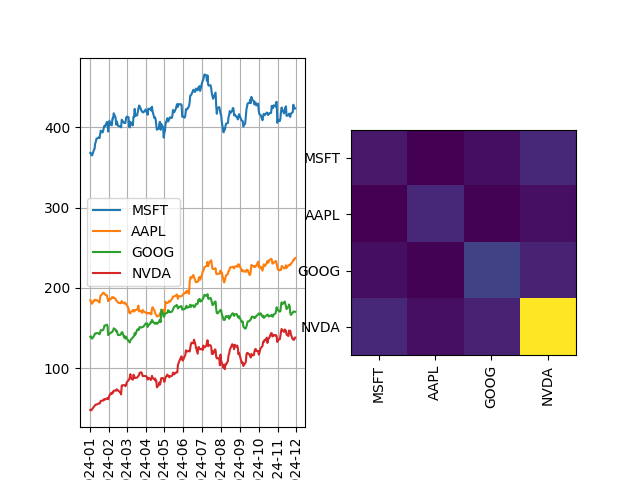

In [3]:
data = None
fig, (ax1, ax2) = plt.subplots(1, 2)


@interact(
    start=widgets.DatePicker(
        description="Start date", value=datetime.datetime(2024, 1, 1)
    ),
    end=widgets.DatePicker(
        description="End date", value=datetime.datetime(2024, 12, 1)
    ),
    tickers=widgets.Textarea(
        description="Tickers", value=",".join(["MSFT", "AAPL", "GOOG", "NVDA"])
    ),
)
def update(start: datetime.datetime, end: datetime.datetime, tickers: str):
    tickers = [ticker.strip() for ticker in (",".join(tickers.splitlines())).split(",")]
    tickers = [ticker for ticker in tickers if ticker]

    global data
    try:
        data = YahooDataProvider(tickers=tickers, start=start, end=end)
        data.run()
    except qiskit_finance.QiskitFinanceError as e:
        # ax1.clear()
        # ax2.clear()
        # raise e
        print(e)
        return

    ax1.clear()
    for ticker, history in zip(data._tickers, data._data):
        ax1.plot(history, label=ticker)
    ax1.legend()
    ax1.tick_params(axis="x", labelrotation=90)
    ax1.grid(True)

    ax2.imshow(data.get_period_return_covariance_matrix())
    ax2.set(
        xticks=[i for i, _ in enumerate(data._tickers)],
        yticks=[i for i, _ in enumerate(data._tickers)],
        xticklabels=[ticker for ticker in data._tickers],
        yticklabels=[ticker for ticker in data._tickers],
    )
    ax2.tick_params(axis="x", labelrotation=90)


mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [10]:
num_assets = len(data._tickers)

@interact(risk_factor=(0.0, 1.0, 0.01), budget=(0, num_assets), penalty=(0, 2*num_assets))
def update(risk_factor: float, budget: int, penalty: int):
    pass

    portfolio = PortfolioOptimization(
        expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget
    )
    qp = portfolio.to_quadratic_program()
    cobyla = COBYLA()
    cobyla.set_options(maxiter=500)
    ry = TwoLocal(len(data._tickers), "ry", "cz", reps=3, entanglement="full")
    svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
    svqe = MinimumEigenOptimizer(svqe_mes)
    result = svqe.solve(qp)
    print(result)

interactive(children=(FloatSlider(value=0.5, description='risk_factor', max=1.0, step=0.01), IntSlider(value=2…

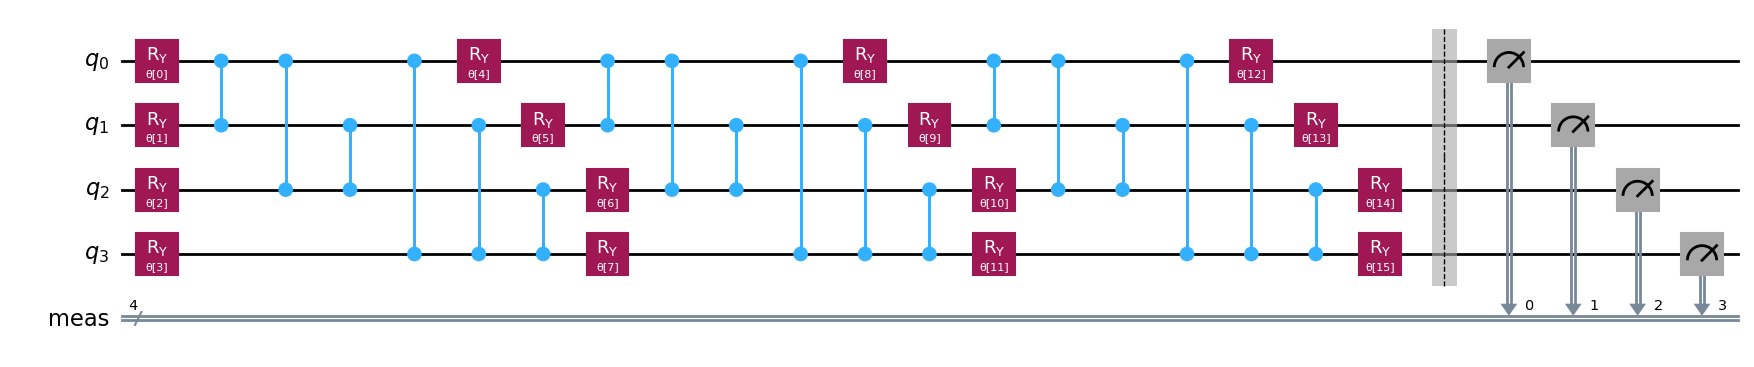

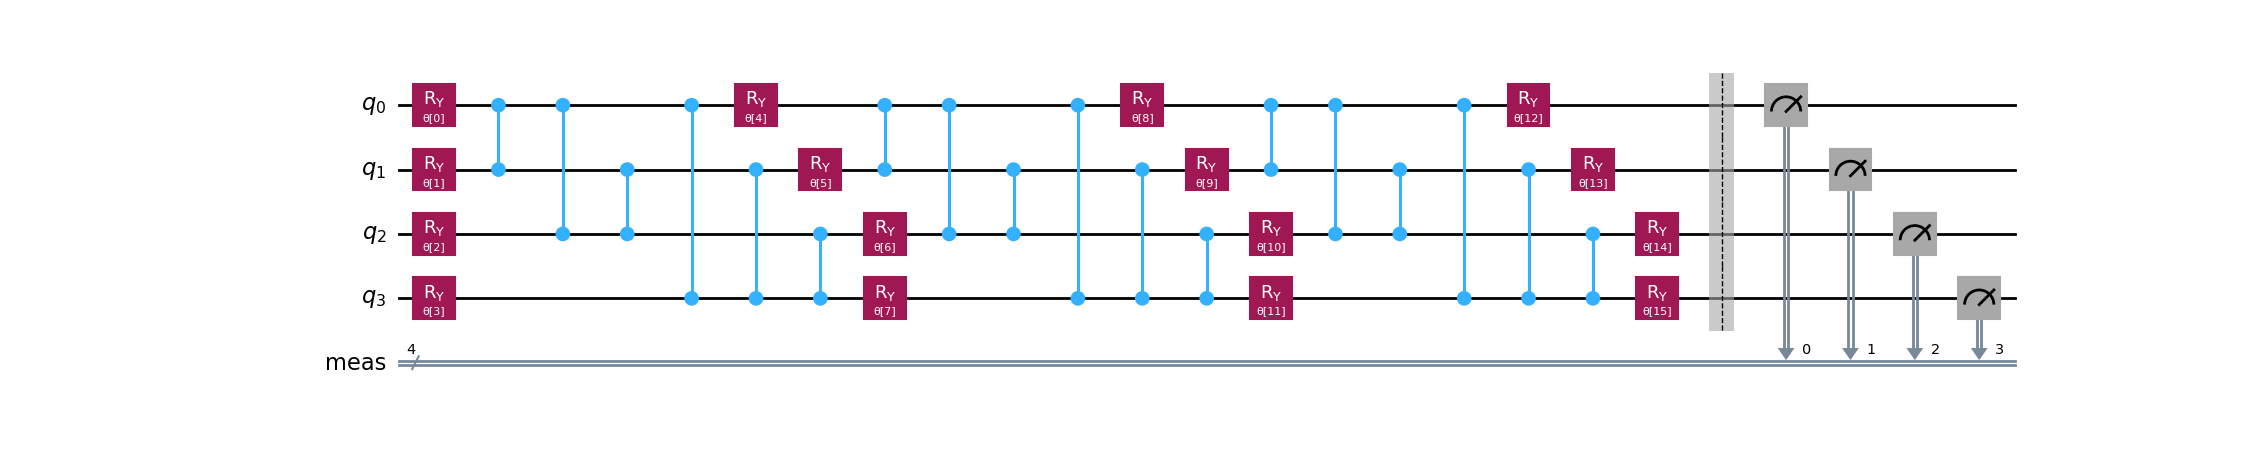

In [10]:
#ry.decompose().draw(output="mpl")